In [1]:
!pip3 install algoliasearch

In [2]:
import pandas as pd
import algoliasearch.search_client
from getpass import getpass

In [3]:
app_id = getpass('Enter the app_id value: ')
api_key = getpass('Enter the api_key value: ')

Enter the app_id value: ··········
Enter the api_key value: ··········


In [4]:
# Initialize Algolia search client
client = algoliasearch.search_client.SearchClient.create(
        app_id, api_key)
index = client.init_index("asknature_searchable_posts")

In [170]:
'''asknature_response = index.search(
        "filters: post_type_label:'Biological%20Strategies'")['hits']
for i in asknature_response:
  print(i)
  #raise NotImplementedError'''

res = index.browse_objects({'query': "", 'attributesToRetrieve': ['summary']})

In [172]:
summaries = []
summaries_dict = {}
ids = []
x = 0
for i in res:
  i["objectID"]
  x += 1
  summ = i["summary"]
  print(i)
  if summ not in summaries:
    ids.append(i["objectID"])
    summaries.append(summ)
print(x)
print(len(summaries))

summaries = summaries[1:]
print(summaries[0])

{'summary': "If you need an offline version of AskNature's content, these pages have you covered.", 'objectID': '110411-0'}
{'summary': 'Leaves full of holes help the Swiss cheese plant capture intermittent light\r\n', 'reference_sources': {'source_title': ['How did the Swiss cheese plant get its holes?'], 'source_link': ['https://www.zoology.ubc.ca/files/Muir_2013.pdf'], 'source_excerpt': ['']}, 'objectID': '110237-0'}
{'summary': 'Moths use changes in speed and altitude to maintain trajectory despite changes in windspeed and direction.', 'reference_sources': {'source_title': ['Study achieves longest continuous tracking of migrating insects', 'Individual tracking reveals long-distance flight-path control in a nocturnally migrating moth'], 'source_link': ['https://www.eurekalert.org/news-releases/961073', 'https://www.science.org/doi/10.1126/science.abn1663'], 'source_excerpt': ['', '<p>Using a light aircraft and individual radio tracking, we show that nocturnally migrating death’s-hea

In [165]:
import nltk
nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package punkt to /Users/eshan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [166]:
# tokenizer that picks out sequences of alphanumeric characters as tokens and drops everything else
# Then lowercase everything 

# Don't remove stop words or lemmatize yet!
# Don't remove digits yet!

tokenizer = RegexpTokenizer(r'\w+')
for i in range(len(summaries)):
  summaries[i] = tokenizer.tokenize(str(summaries[i]))
  summaries[i]  =  " ".join([word.lower() for word in summaries[i]])

'''summaries = summaries[1:]
nltk.pos_tag(summaries[1])'''
print(summaries[-1])

halobacteria produce chemical energy by capturing light energy with rhodopsin pigments and using it to pump protons out of the cell setting up a proton gradient used to generate atp


In [167]:
# check for duplicates
len(summaries) != len(set(summaries))
### there are duplicates

True

In [169]:
summaries = list(set(summaries))
len(summaries)

2067

## Let's start with discrete document representation.
- TF-IDF for document representation
  - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [176]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X = vectorizer.fit_transform(summaries).toarray()
print(X.shape)
print(vectorizer.get_feature_names_out())

(2068, 63313)
['000' '000 beats' '000 beats per' ... 'µlot' 'µlot platform'
 'µlot platform technology']


In [177]:
!pip3 install kneed

In [178]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Silhouette Analysis - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# How to find elbow in Scree Plot - https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python


In [179]:
K_params = [i + 1 for i in range(50)]

within_cluster_variation = []
between_cluster_variation = []
CH_index = []
for k in K_params:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    within_cluster_variation.append(kmeans.inertia_)
    labels = kmeans.labels_
    if k != 1:
        between_cluster_variation.append(davies_bouldin_score(X, labels))
        CH_index.append(calinski_harabasz_score(X, labels))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


# Within-cluster variation 


*   measure the amount by which the observations within each cluster 
*   differ from each other. 
*   The lower it is, the better.


<br>

> $minimize_{C_1,...,C_k} = {\sum^K_{k=1}WCV(C_k)}$

> $WCV(C_k) = \frac{1}{|C_k|}\sum_{i,i' \in C_k} \sum^p_{j=1}(x_{ij} - x_{i'_j})^2$

> $|C_k|$ denotes the number of observations in the kth cluster. 

> $\sum_{i,i' \in C_k} \sum^p_{j=1}(x_{ij} - x_{i'j})^2$ denotes the euclidean distance of all pairs in the cluster.

<br>


* Putting it all together, split the observations into K clusters such that the total WCV is as small as possible.
* However, the WCV will always decrease as the number of clusters increase. This is because there are less observations in the cluster, thereby making the cluster smaller and the observations in the cluster closer together. 

* So, we must make a tradeoff and choose an "elbow/knee" on the plot. This is known as a Scree plot.

* The elbow is a k, where drops in WCV(k) are not very significant after k increases.

In [180]:
kn = KneeLocator(K_params, within_cluster_variation, curve='convex', direction='decreasing')
opt_k = kn.knee
print(opt_k)

42


In [181]:
within_cluster_variation[49]

1988.5295166388928

### Optimal number of clusters is 42. 

In [182]:
import matplotlib.pyplot as plt

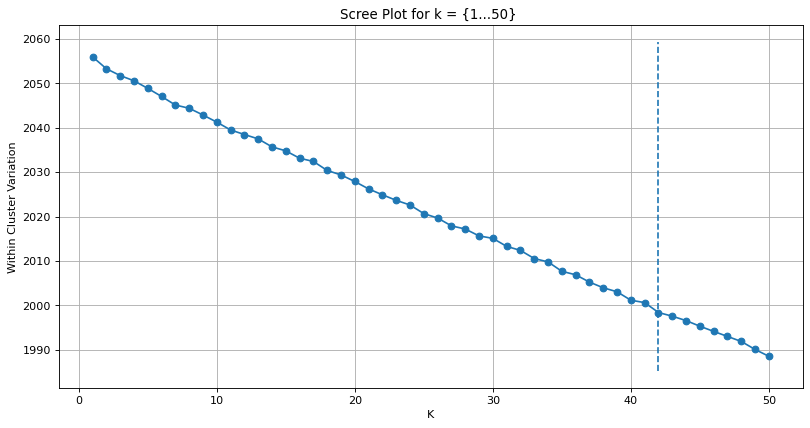

In [183]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(K_params,within_cluster_variation, marker='o')
plt.title('Scree Plot for k = {1...50} ')
plt.xlabel('K')
plt.ylabel('Within Cluster Variation')
plt.grid(True)

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# Silhouette Analysis
*   graph representation of how well each observation lies within its cluster.

### $a_i$
*  For each sample x_i, let a_i be the average distance between x_i and all other data within the same cluster.
* a_i can be interpreted as a measure of how well x_i is assigned to its cluster. 
* the smaller the value, the better it fits its cluster. 

### $b_i$
*  This is the lowest average distance of x_i to all points in any other cluster, which x_i is not a member of. 
* This is the neighboring cluster, or cluster closest to data point x_i. It is the next best fit cluster. 


### $s_i$

$s_i = \frac{b_i - a_i}{max(a_i, b_i)}$

* if a_i < b_i, s_i is positive, meaning it is a good fit to it's cluster.
* if a_i == b_i, it could belong to its cluster or the neighboring cluster. 
* if a_i > b_i, x_i belongs to it's neigboring cluster.

* Therefore, s_i closer to 1 means its appropriately clustered, and the average s_i over a cluster measure how tightly grouped the data is in the cluster. 

* We want a higher average.

### Etc

* If there are too many or too few clusters, some of the clusters will display narrower silhouettes. 
* We also don't want a lot of negative silhouette scores.




In [184]:
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
# Silhouette Analysis - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [ ]:
opt_avg_silhouette_score = float("-inf")
opt_k_silhouette = 0
opt_cluster_labels = []

for k in K_params[1:]:
    print(k)
    clusterer = KMeans(n_clusters=k, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    if silhouette_avg > opt_avg_silhouette_score:
      opt_avg_silhouette_score = silhouette_avg
      opt_k_silhouette = k
      opt_cluster_labels = cluster_labels
    

Optimal num_clusters = 48 Optimal average silhouette_score is : 0.0009473666314819962



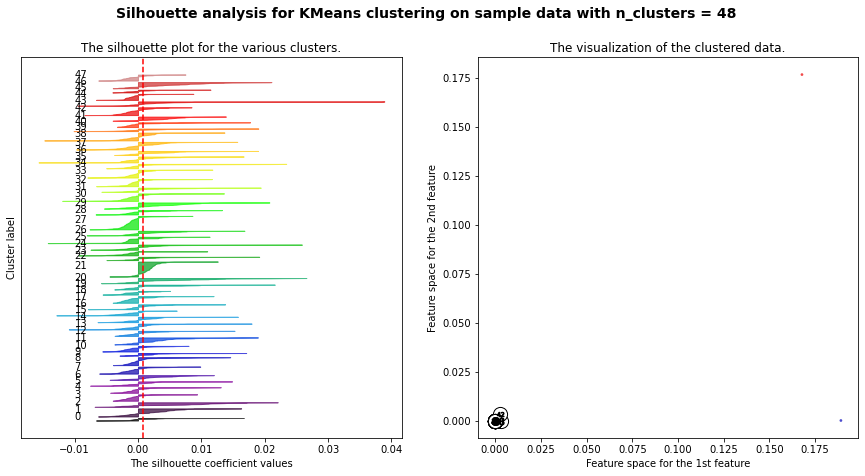

In [219]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

#ax1.set_xlim([-0.1, 1])

#ax1.set_ylim([0, len(X) + (k + 1) * 10])

print(
      "Optimal num_clusters =",
      opt_k_silhouette,
      "Optimal average silhouette_score is :",
      opt_avg_silhouette_score,
  )

print()

sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10

for i in range(opt_k_silhouette):
      
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / opt_k_silhouette)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax1.text(-0.01, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10 

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")


ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([]) 
#ax1.set_xticks([-0.001, 0, 0.002, 0.004, 0.006, 0.008, .01])


colors = cm.nipy_spectral(cluster_labels.astype(float) / opt_k_silhouette)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)


centers = clusterer.cluster_centers_

ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

#ax2.set_xlim([-0.00001, 0.00001])

#ax2.set_ylim([-0.0001, 0.0001])

#ax2.set_xticks([-0.001, 0, 0.002, 0.004, 0.006, 0.008, .01])

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % opt_k_silhouette,
    fontsize=14,
    fontweight="bold",
)

plt.show()

### It looks as though the silhouette plots are poor. There are too many clusters indicated by the fact that the silhouettes are narrow. Additionally there a large amount of negative values.

### However, the scree plot method and silhouette plot method yielded a similar number of optimal clusters. 

### We probably have to try different document representation later. 

### I will choose k = 42, received from the scree plots


# Let's check the data in each cluster.

In [187]:
opt_k

42

In [188]:
# number of samples that are not 0
len(np.nonzero(X)[0])

103251

In [189]:
km = KMeans(n_clusters=opt_k).fit(X)
print(km.labels_)

[ 2 10 16 ... 28 26 23]


In [190]:
len(km.labels_) == len(summaries)

True

In [191]:
result_df = pd.DataFrame()
for i in range(len(summaries)):
  result_df = pd.concat([result_df, 
                                pd.DataFrame.from_records([{
                                    "Summary": summaries[i], 
                                    "Cluster": km.labels_[i],  
                                }])], ignore_index=True)

In [192]:
not result_df["Summary"].is_unique 

False

In [193]:
result_df

,Summary,Cluster
0,Leaves full of holes help the Swiss cheese pla...,2
1,Moths use changes in speed and altitude to mai...,10
2,Bestselling science author Steve Brusatte pain...,16
3,Tiny leg hairs help spiders sense subtle air m...,41
4,Explore a selection of biomimetic innovations ...,34
...,...,...
2063,The eggs of many fish are buoyant due to the p...,16
2064,The feathers of birds and fur of mammals help ...,13
2065,Thigh bones of birds and mammals withstand str...,28
2066,Chromatophores in cephalopods provide active c...,26


In [194]:
print(result_df.loc[8, "Summary"])
print(result_df.loc[9, "Summary"])
print()

Flying squirrels have membranes and cartilage that help them change lift and drag forces, enabling them to glide more than 100 times their body length.
When bull snakes and their relatives bellow in defense, tissue boosts air flow as it passes over a single vocal cord to create an initial burst of sound.




In [195]:
result_df.loc[result_df['Cluster'] == 5][:5]

,Summary,Cluster
17,Invented to deter harmful particle buildup in ...,5
121,Waterboxx plant cocoon from Groasis creates a ...,5
132,The Cocoon from Land Life Company creates a no...,5
186,A standards-aligned engineering curriculum for...,5
241,BioMimics 3D Swirling Flow Stent from Veryan i...,5


In [197]:
print(result_df.loc[17, "Summary"])
print(result_df.loc[121, "Summary"])

Invented to deter harmful particle buildup in medical devices, design also could be used in industrial pipes and more.

Waterboxx plant cocoon from Groasis creates a nourishing, protective environment that helps seedlings grow in dry, arid conditions.



In [198]:
result_df.loc[result_df['Cluster'] == 0].index

Int64Index([  72,  114,  116,  119,  142,  143,  144,  154,  155,  156,  157,
             158,  159,  162,  163,  167,  169,  171,  173,  174,  177,  178,
             179,  180,  181,  182,  183,  184,  185,  189,  192,  193,  196,
             197,  198,  204,  215,  238,  251,  264,  265,  295,  299,  425,
             471,  480,  539,  563,  592,  944, 1106, 1180, 1247, 1623, 1729,
            1795, 1947, 1996, 2047],
           dtype='int64')

In [224]:
X_samples_0_cluster = X[result_df.loc[result_df['Cluster'] == 0].index]
avg_num_samples = []
for k in range(opt_k):
  avg_num_samples.append(len(result_df.loc[result_df['Cluster'] == k].index))

### around 49 samples per cluster
print(sum(avg_num_samples)/opt_k)

49.23809523809524


In [200]:
km.cluster_centers_

array([[ 8.13151629e-20,  5.42101086e-20,  5.42101086e-20, ...,
        -6.77626358e-20, -6.77626358e-20, -6.77626358e-20],
       [-2.71050543e-20,  1.35525272e-20,  1.35525272e-20, ...,
        -1.35525272e-20, -1.35525272e-20, -1.35525272e-20],
       [ 2.71050543e-20,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 8.13151629e-20,  2.71050543e-20,  2.71050543e-20, ...,
        -6.77626358e-20, -6.77626358e-20, -6.77626358e-20],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.71050543e-20,  1.35525272e-20,  1.35525272e-20, ...,
        -1.35525272e-20, -1.35525272e-20, -1.35525272e-20]])

In [225]:
for k in range(opt_k):
  d = km.transform(X)[:, k]
  ind = np.argsort(d)[::][:11]
  print(ind)
  for i in ind:
    print(summaries[i])
  #raise NotImplementedError
  print()
  print()

[454 251 264 173 119 154 265 189 114 177 169]

This collection of activities for grades 3-5 provides ideas and strategies for tying biomimicry into science and engineering design standards.
This collection of activities provides a high school level introduction to the concept of biomimicry, along with instruction to support student use of the resources on the AskNature website to apply biomimicry to any design challenge.
This publication provides an introduction to biomimicry with teaching strategies for K-12 educators and others who work with youth.
This 50-minute activity provides an introduction to biomimicry and quickly gets students brainstorming design ideas.
This 22-minute film provides a firsthand perspective of how the Biomimicry Institute is pioneering an open-access platform for nature-inspired design and teaching biomimicry through design challenges.
This collection of activities provides hands-on methods for students in grades K-2 to explore the natural world, learn to mak